In [1]:
import numpy as np # library to handle data in a vectorized manner
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means and AffinityPropagation for clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AffinityPropagation
from sklearn import preprocessing
from sklearn import metrics
import folium # map rendering library
from folium.plugins import MarkerCluster
from folium import IFrame # To make pop/up labels
# Libraries which will help reading and working with geojson file as it would be regular pandas DF
import geopandas as gpd 
from geopandas import GeoDataFrame
import fiona
# These will help with spatial indexing
import osmnx as ox
ox.config(log_file=True, log_console=True, use_cache=True)
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
from pandas import read_excel
from bs4 import BeautifulSoup # for data scraping from webpage
# Thanks to these imports we can simply define the colors we want, and the index (thresholds) that correspond
import os
import branca
import branca.colormap as cm
from branca.element import Template, MacroElement # To make a legend
%matplotlib inline
print('Libraries imported.')

Libraries imported.


## Building the basic map with city districts

__Prague__ has surface area of 496 square kilometres. There are 10 municipal areas which consist of 22 administrative areas, 57 city districts and 112 cadastral territories. 

Now we will try to built a map of Prague with its city districts, but we will have a look at cadastrals as well so we can later decide which will suit us more in our project.

In [2]:
# downloading geojson file with 57 city districts coordinations
!wget --quiet http://opendata.iprpraha.cz/CUR/DTMP/TMMESTSKECASTI_P/WGS_84/TMMESTSKECASTI_P.json -O prg_districts.json

In [3]:
# checking the dataset with districts using GeoPandas which is showing us json file as Pandas dataframe
districts = gpd.read_file("prg_districts.json")
districts.head(2)

,OBJECTID,DAT_VZNIK,DAT_ZMENA,PLOCHA,ID,KOD_MC,NAZEV_MC,KOD_MO,KOD_SO,TID_TMMESTSKECASTI_P,POSKYT,ID_POSKYT,STAV_ZMENA,NAZEV_1,Shape_Length,Shape_Area,geometry
0,1,20160422155519,20160603135317,4988983.97,46,547301,Praha-Dolní Chabry,86,86,46,HMP-IPR,43,U,Dolní Chabry,0.147442,4.988984e+06,"POLYGON ((14.43611454600006 50.15192743600005,..."
1,2,20180613112036,20180613132603,1786429.18,57,547395,Praha-Petrovice,108,159,57,HMP-IPR,43,U,Petrovice,0.090167,1.786429e+06,"POLYGON ((14.54928140500004 50.02752104500007,..."


In [4]:
# The geometry column contains all the locations for each districts' border, so it's quite large and it wuld take a lot of time to render it on map
# We've used "https://mapshaper.org/" to simplify above json file so that future map will load slightly quicker and stored new file to the github for later use.
# We will work with this one from now on.
!wget --quiet https://raw.githubusercontent.com/JakubVoros/Coursera_Capstone_The_Finale/master/prg_districts_2.json -O prg_districts_2.json

In [5]:
districts2 = gpd.read_file("prg_districts_2.json") # Saving the file for later use
districts2.head(1)

,OBJECTID,DAT_VZNIK,DAT_ZMENA,PLOCHA,ID,KOD_MC,NAZEV_MC,KOD_MO,KOD_SO,TID_TMMESTSKECASTI_P,POSKYT,ID_POSKYT,STAV_ZMENA,NAZEV_1,Shape_Length,Shape_Area,geometry
0,1,20181106141412,20181106164427,10183715.85,25,547310,Praha-Čakovice,94,221,25,HMP-IPR,43,U,Čakovice,0.213162,1.018372e+07,"POLYGON ((14.56048437200008 50.15536430700007,..."


## Scrapping Informations about Rents

Because our map will show us different districts, we will try to incomporate the rent into it and now we just need to get the information and prepare it.

#### Getting needed data about rent from webpage and scraping it with BeautifulSoup


In [6]:
# average rent per m²/month
html_doc = requests.get('https://realitymix.centrum.cz/statistika-nemovitosti/byty-pronajem-prumerna-cena-pronajmu-1m2-mesic.html').text
soup = BeautifulSoup(html_doc, 'lxml')

In [7]:
# scraping necessary information and setting a new dataframe
table = soup.find('table',{'cellpadding':'0'})
column =[ 'District', '02/2018*m²', '12/2018*m²',  '01/2019*m²', '02/2019*m²']
rent = pd.DataFrame(columns = column)


#### Using loop to get all the informationt into the rent Dataframe

In [8]:
# Loopin over table rows (tr tag) and getting the text of cells (td tag)
# Cleaning texts from unnecessary signs ("\n") etc.
# Inserting everything into the dataframe

for tr in table.find_all('tr')[15:]:
    tds = tr.find_all('td')  
    d = tds[0].text
    uo = tds[1].text
    po = tds[2].text
    ld = tds[3].text
    ud = tds[4].text        
    rent = rent.append({'District' : d, '02/2018*m²': uo,
                                          '12/2018*m²': po, '01/2019*m²' : ld, '02/2019*m²': ud }, ignore_index=True)

In [9]:
# using districts' names as indexes
rent.set_index("District",inplace=True)

In [10]:
# The average rent in area is based on municipal districts, each of those consists of city districts and with those we are working here.
rent = rent.astype('int')
rent = rent.transpose() # Swaping indexes(districts) and columns (dates) so we will rotate the graph
rent.to_csv('rent.csv')

In [11]:
rent = pd.read_csv('rent.csv', index_col = 'Unnamed: 0')
rent.head(4)

,Praha 1,Praha 2,Praha 3,Praha 4,Praha 5,Praha 6,Praha 7,Praha 8,Praha 9,Praha 10
02/2018*m²,431,402,354,279,348,313,330,300,293,282
12/2018*m²,439,392,353,287,349,314,334,314,293,300
01/2019*m²,443,395,352,287,352,311,329,325,295,300
02/2019*m²,445,404,352,281,348,307,337,327,299,302


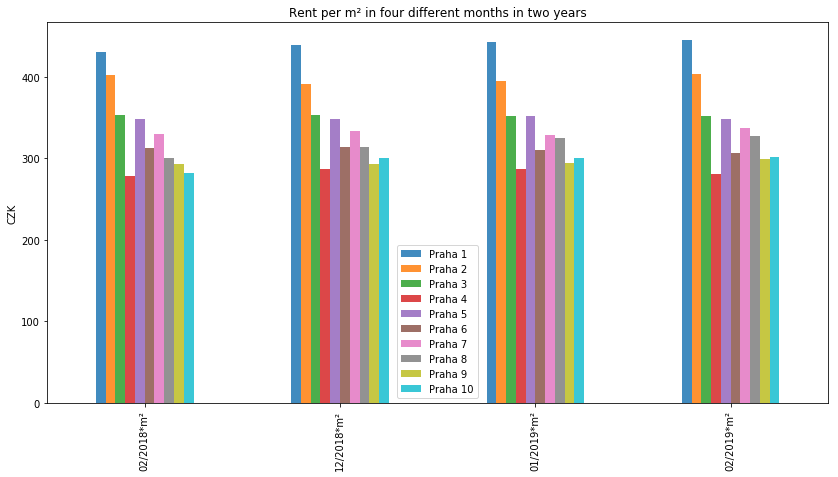

In [12]:
# Preview on average rents in ten municipal districts
rent.plot(kind="bar",alpha=0.85,figsize=(14,7), legend=True)
plt.title('Rent per m² in four different months in two years')
plt.ylabel('CZK')
plt.show()

We have now a basic idea about the rent in each of the ten municipal districts. We can see that the most expensive area is Praha 1 and the cheapest Praha 4 and we can say that all the prices don't grow that quickly in a matter of a one year.

### Second dataset with rents but now directly for those 57 districts

In [13]:
# To have just ten averages of rents for such a large area is quite insufficient
# So we will work with a dataframe which is based on http://www.cenovamapa.eu/ and contains 57 averages for each district.
!wget --quiet https://github.com/JakubVoros/Coursera_Capstone_The_Finale/blob/master/najmy_praha.xlsx?raw=true -O prg_rents.xlsx

In [14]:
# Reading the DF into rents_2
rents_2 = pd.read_excel('prg_rents.xlsx')
rents_2.head(2)

,District,Rents_m²/CZK
0,Čakovice,160
1,Praha 14,160


In [15]:
# Creating  new Df out of "rents_2" with "District" as the index names and preparing min and max values for colormap threshold 
rents_series = rents_2.set_index('District')['Rents_m²/CZK']
min1 = int(rents_series.min()) -10
max2 = int(rents_series.max()) +10

In [16]:
# Loading the geojson file with districts' locations, so we can add all the data we acquired so far into our map
h = os.path.join('prg_districts_2.json')
geo_json_data = json.load(open(h))


In [17]:
# Exploring what are the most common rents so we can later on make them into steps, which will help distribute specific colour for each area(plus colormap)
vc = rents_series.value_counts()
print(vc)

145    8
165    8
155    6
200    4
175    4
160    4
135    2
140    2
210    2
170    2
150    2
215    2
205    1
190    1
95     1
185    1
100    1
110    1
430    1
240    1
180    1
120    1
225    1
Name: Rents_m²/CZK, dtype: int64


In [18]:
# Preparing steps and choosing colours. Each district will have specific colour based on its average rent. 
i = [85,140,145,155,160,165,200,420,440]

# We use branca libraries to set a step colormap with eight sections for different rents range
step = cm.StepColormap(
    ['MediumSpringGreen','blue', '#ffff00','LawnGreen', 'gray', 'magenta', 'orange', (255/255,0/255,43/255)],
    vmin=50, vmax=max2,
    index=i,
    caption='step'
)


In [19]:
# Getting latitude and longitude for Prague using Nominatim
address = 'Praha'

geolocator = Nominatim(user_agent="prague_move")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Prague are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Prague are 50.0874654, 14.4212535.


In [20]:
# This is our main map plotted with districts, coloured with average rents.
m = folium.Map(
    location=[latitude, longitude],
    tiles='cartodbpositron',
    zoom_start=11
)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': step(rents_series[feature['properties']['NAZEV_1']]),
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    },
    tooltip=folium.GeoJsonTooltip(fields=['NAZEV_1'],
                                    labels=False,
                                    sticky=False)
).add_to(m)

m

## Building a Dataset for Districts' Coordinations, Area/Radius which will be used for Foursquare

For the next part, we will try to be a little bit more thorough. And to be so, we will try to work with cadastrals instead just of districts and so we will get more details on each area.

Because we want to get some basic overview of all areas, we will use Foursquare which will give us informations of all the venues and other interesting places which are located her and so they might at the end help us make our mind.

To use Foursquare we need to enter a specific location. So we need to get a name, longtitude, latitude, area.

In [21]:
# Getting DF with names of 112 cadastral districts
html_doc2 = requests.get('https://cs.wikipedia.org/wiki/Seznam_katastr%C3%A1ln%C3%ADch_%C3%BAzem%C3%AD_Prahy_podle_po%C4%8Dtu_obyvatel').text
soup2 = BeautifulSoup(html_doc2, 'lxml')

In [22]:
# Setting new DF
table2 = soup2.find('tbody')  
column2 =[ 'Name_cad', 'Area/ha', 'Latitude', 'Longitude']
cad = pd.DataFrame(columns = column2)
cad

,Name_cad,Area/ha,Latitude,Longitude


In [23]:
# Scraping necessary information (name and area) and setting a new dataframe
# Loopin over table rows (tr tag) and getting the text of cells (td tag)
# Cleaning texts from unnecessary signs ("\n") etc.
# Inserting everything into the dataframe

for tr in table2.find_all('tr')[1:]:
    tds = tr.find_all('td')  
    uo = tds[5].text
    d = tds[1].text    
    cad = cad.append({'Name_cad' : d, 'Area/ha': uo}, ignore_index=True)

Now we will use Nominatim to get coordinations for each cadastral.

In [24]:
# A few of the cadastral names have to be sligtly altred, because otherwise Nominatim and later Osmnx would swaped those cadastrals for other places
# To do so we have prepared two lists. A "norm" list containg original versions of those few names and a "spec" list with names already in correct versions for Nominatim/Osmnx.
# We will compare "norm" with cad["'Name_cad'"] and if the names are same, we add theirs altered version from "spec" into a new column in "cad".
spec = ['Stodůlky, Praha ', 'Chodov,  Praha ', 'Krč,140 00 Praha', 'Háje, Praha', 'Kamýk, 142 00 Praha', 'Prosek, Praha', 'Vysočany, Praha ', 'Podolí, 147 00 Praha', 'Staré Město, Praha ',  'Radotín, Praha ', 'Lhotka, 142 00 Praha 4', 'Petrovice, Praha', 'Malá Strana, Praha ', 'Dubeč,  Praha', 'Komořany, Praha', 'Miškovice, Praha', 'Sedlec, Prague', 'Točná, 143 00 Praha 12 ', 'Benice, 103 00 Praha ', 'Královice, 104 00 Praha ', 'Lipany, Praha ', 'Vyšehrad, 128 00 Praha', "Malešice, 108 00 Praha 10", "Kolovraty, Prague, okres Hlavní město Praha, Praha 10"]
norm = ['Stodůlky', 'Chodov', 'Krč', 'Háje', 'Kamýk', 'Prosek', 'Vysočany', 'Podolí', 'Staré Město',  'Radotín', 'Lhotka', 'Petrovice', 'Malá Strana', 'Dubeč', 'Komořany', 'Miškovice', 'Sedlec', 'Točná', 'Benice', 'Královice', 'Lipany', 'Vyšehrad', "Malešice", "Kolovraty"]
for i, x in enumerate(norm):
    cad.loc[cad['Name_cad'] == x, "new_name"] = spec[i]

In [25]:
# Adding the rest which doesn't need adjustment into the new column
cad.loc[cad["new_name"].isnull(), "new_name"] = cad['Name_cad']

In [26]:
cad.head(3)

,Name_cad,Area/ha,Latitude,Longitude,new_name
0,Stodůlky,962,NaN,NaN,"Stodůlky, Praha"
1,Žižkov,544,NaN,NaN,Žižkov
2,Chodov,743,NaN,NaN,"Chodov, Praha"


In [27]:
# getting locations for each cadastral district centre
for i in cad.index:
    if pd.isna(cad.at[i, 'Latitude']) == pd.isna(np.nan): # even if it won't fill DF on a first try and end with error (GeocoderUnavailable: Service not available), thanks to 'if' code you can just retry this 'for' loop till DF is full
        geolocator = Nominatim(user_agent="prague_move_districts")
        geo = geolocator.geocode('{}, Prague, Hlavní město Praha'.format(cad.at[i, "new_name"])) 
        cad.at[i, 'Latitude'] = geo.latitude
        cad.at[i, 'Longitude'] = geo.longitude


In [28]:
cad.set_index('Name_cad',inplace=True) # settin the original cadastrals' names as indexes
print(cad.shape)
cad.head()

(112, 4)


,Area/ha,Latitude,Longitude,new_name
Name_cad,,,,
Stodůlky,962,50.0483,14.3124,"Stodůlky, Praha"
Žižkov,544,50.0811,14.4549,Žižkov
Chodov,743,50.0328,14.5016,"Chodov, Praha"
Vinohrady,379,50.0754,14.4364,Vinohrady
Vršovice,293,50.0719,14.4727,Vršovice


In [29]:
# calculating approximate radius from "Area/ha" for each district (very approximate...)
cad['Area/ha'] = cad['Area/ha'].astype('int')
cad['Area/ha'] = round(np.sqrt((cad['Area/ha']*10000)/3.14),)
cad.rename(columns = {'Area/ha': 'Radius'},inplace = True)

In [30]:
# Saving DF of cadastrals and their centre locations and radiuses
cad.to_csv('cadastral_districts.csv')

In [31]:
cad.head(2)

,Radius,Latitude,Longitude,new_name
Name_cad,,,,
Stodůlky,1750.0,50.0483,14.3124,"Stodůlky, Praha"
Žižkov,1316.0,50.0811,14.4549,Žižkov


## Foursquare dataset

#### Define Foursquare Credentials and Version

In [32]:
# Importing here my private setting with Foursquare ID and Code, You have to enter here yours
import settings
CLIENT_ID = settings.API_ID # your Foursquare ID
CLIENT_SECRET = settings.API_KEY # your Foursquare Secret
VERSION = '20190301' # Foursquare API version

LIMIT = 200


####  Function to Explore Districts

In [33]:
# Function which will collect top (limit 200) venues around cadastral center location in radius = all from DF
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Explored')
    return(nearby_venues)

### Top Venues in Each District with Coordinations and Category

In [34]:
# Using above function, so we will get a new DF with all the venues in each cadastral
prague_venues = getNearbyVenues(names = cad.index,
                                   latitudes = cad['Latitude'],
                                   longitudes = cad['Longitude'],
                                radius = cad['Radius'])

Explored


In [35]:
prague_venues.to_csv('prague_venues.csv') # saving for later
print(prague_venues.shape) # Exploring
prague_venues.rename(columns={'Neighborhood':'Cad_Neighborhood'},inplace = True) 
prague_venues.head(10)

(4617, 7)


,Cad_Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stodůlky,50.048307,14.312404,Puzzle Salads,50.046955,14.306649,Salad Place
1,Stodůlky,50.048307,14.312404,La Zmrzka,50.046439,14.303685,Ice Cream Shop
2,Stodůlky,50.048307,14.312404,Bartga Bistro,50.048344,14.306519,Pizza Place
3,Stodůlky,50.048307,14.312404,Red Café Prague,50.046695,14.305223,Café
4,Stodůlky,50.048307,14.312404,Form Factory,50.047435,14.305949,Gym / Fitness Center
5,Stodůlky,50.048307,14.312404,Srdcovka U Drsnejch,50.044602,14.321267,Restaurant
6,Stodůlky,50.048307,14.312404,Bernard Pub U Jezera,50.046921,14.324759,Restaurant
7,Stodůlky,50.048307,14.312404,IKEA Bistro,50.051146,14.297547,Bistro
8,Stodůlky,50.048307,14.312404,Centrální park,50.047929,14.331481,Park
9,Stodůlky,50.048307,14.312404,Starbucks,50.049742,14.297640,Coffee Shop


In [36]:
# Checking with how many unique venues will we be working 
print('There are {} uniques categories.'.format(len(prague_venues['Venue Category'].unique())))

There are 350 uniques categories.


#### One-hot Encoding venues into unique categories

In [37]:
# We are not interested in venues names addresses.. but in categories and how many are there in each cadastral
# So we will use Pandas' "get_dummies" on venue column. That will transfer each unique venue into a new column and then assign 0 or 1 value into each row depanding on if 
#we can find this specific venue in this specific cadastral
onehot = pd.get_dummies(data = prague_venues, drop_first  = False, 
                              prefix = "", prefix_sep = "", columns = ['Venue Category'])
onehot.head(2)

,Cad_Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Carpet Store,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish Market,Fishing Store,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Nightclub,Noodle House,Nudist Beach,Observatory,Office,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Bathroom,Racecourse,Racetrack,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopp

In [38]:
# Getting rid of unnecessary columns
onehot_prg = onehot.drop(labels=['Neighborhood Latitude', 'Neighborhood Longitude','Venue', 'Venue Latitude', 'Venue Longitude'], axis=1)
onehot_prg.to_csv('onehot_prg.csv')
print(onehot_prg.shape)

(4617, 351)


In [39]:
# Grouping everything under cadastral districts, so we will get total amount of each unique venue category for all the cadastrals
onehot_prg2 = onehot_prg.groupby('Cad_Neighborhood',axis=0).sum().reset_index()
onehot_prg2.to_csv('onehot_prg2.csv')
print(onehot_prg2.shape)
onehot_prg2.head()

(112, 351)


,Cad_Neighborhood,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Carpet Store,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish Market,Fishing Store,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Nightclub,Noodle House,Nudist Beach,Observatory,Office,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Bathroom,Racecourse,Racetrack,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Shop,Smoke Shop,Snack Place,Soccer 

#### Integrating different categories, which could be grouped together

In [40]:
#There is still quite a large group of venues to work with, so we have to group them more

# Making a list of unique categories and trying to figure out how to group them

l = list(onehot_prg2.columns.unique())
onehot_prg2.set_index('Cad_Neighborhood')
onehot_prg2.tail()

,Cad_Neighborhood,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Carpet Store,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish Market,Fishing Store,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Nightclub,Noodle House,Nudist Beach,Observatory,Office,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Bathroom,Racecourse,Racetrack,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Shop,Smoke Shop,Snack Place,Soccer 

In [41]:
# Trying to group categories, everything done by hand
# All categories are divided and listed in more general groups and those are added back in DF and those individual categories are droped
restaurants = []
cafe = []
park = []
pr = []
sports = []
pub = []
bed = []
meals = []
clothes = []
leisure = []
food = []
trans = []
mus = ['Canal','Canal Lock','Harbor / Marina','Port','Surf Spot','River','Island']
store = []
ot = ['IT Services',"Government Building",'Office', "Tourist Information Center",'Pedestrian Plaza','Convention Center', 'Tattoo Parlor','Recording Studio','Film Studio', 'Intersection','Lounge','Plaza','Bank', 'Insurance Office','Road','Roof Deck','Tunnel','Rental Car Location','Rental Service']


# We are looping through the categories list and spliting venues into more general groups
for i, value in enumerate(l):
    if value.find('Restaurant') != (-1) or value == 'Steakhouse' or value == 'Trattoria/Osteria' or value == 'Diner'\
    or value.find('Joint') != (-1):
        restaurants.append(value)
    elif value.find('Coffee') != (-1) or value.find('Café') != (-1) :
        cafe.append(value)
    elif value == 'Park' or value == 'National Park':
        park.append(value)
    elif value == 'Parking' :
        pr.append(value)
    elif value == 'Athletics & Sports' or value == 'Badminton Court' or value == 'Baseball Field' or value == 'Baseball Stadium'\
    or value == 'Basketball Court' or value == 'Bathing Area' or value == 'Bike Trail' or value == 'Bowling Alley'\
    or value == 'Climbing Gym' or value == 'College Gym' or value == 'Dance Studio' or value == 'Disc Golf' or value == 'Go Kart Track'\
    or value == 'Golf Course' or value == 'Golf Driving Range' or value == 'Gun Range' or value == 'Gym' or value == 'Gym / Fitness Center'\
    or value == 'Gym Pool' or value == 'Hockey Field' or value == 'Hockey Rink' or value == 'Laser Tag' or value == 'Martial Arts Dojo'\
    or value == 'Mini Golf' or value == 'Pool' or value == 'Pool Hall' or value == 'Racecourse' or value == 'Racetrack'\
    or value == 'Skate Park' or value == 'Skating Rink' or value == 'Ski Area' or value == 'Squash Court' or value == 'Stables'\
    or value == 'Swim School' or value == 'Tennis Court' or value == 'Track' or value == 'Track Stadium' or value == 'Trail'\
    or value == 'Volleyball Court' or value == 'Yoga Studio' or value.find('Stadium') != (-1) or value.find('Arena') != (-1)\
    or value == 'Indoor Play Area' or value.find('Field') != (-1) or value == 'Sports Club' or value == 'Pilates Studio'\
    or value == "Rugby Pitch" or value == 'Rock Climbing Spot':
        sports.append(value)
    elif value.find('Beer') != (-1) or value.find('Pub') != (-1) or value == 'Gastropub' or value.find('Bar') != (-1) or value == 'Brewery'\
    or value.find('Nightclub') != (-1) or value == 'Other Nightlife':
        pub.append(value)
    elif value.find('Bed') != (-1) or value.find('Campground') != (-1) or value.find('Hostel') != (-1) or value.find('Hotel') != (-1)\
    or value == 'Motel' or value == 'Boarding House' or value == 'Building' or value == 'Residential Building (Apartment / Condo)':
        bed.append(value)
    elif value == 'Bistro' or value == 'Breakfast Spot' or value == 'Bubble Tea Shop' or value == 'Buffet' or value == 'Bakery'\
    or value == 'Burrito Place' or value == 'Cafeteria' or value == 'Creperie' or value == 'Cupcake Shop'\
    or value == 'Dessert Shop' or value == 'Donut Shop' or value == 'Food Court' or value == 'Food Stand' or value == 'Food Truck'\
    or value == 'Frozen Yogurt Shop' or value == 'Ice Cream Shop' or value == 'Noodle House' or value == 'Pastry Shop' or value == 'Pelmeni House'\
    or value == 'Pizza Place' or value == 'Sandwich Place' or value == 'Salad Place' or value == 'Snack Place' or value == 'Soup Place'\
    or value == 'Deli / Bodega' or value == 'College Cafeteria' or value == 'Food Service':
        meals.append(value)
    elif value.find('Boutique') != (-1) or value.find('Clothing') != (-1) or value == 'Kids Store' or value == "Men's Store"\
    or value.find('Shoe') != (-1) or value == "Women's Store" or value == "Lingerie Store" or value == 'Adult Boutique' or value == 'Baby Store'\
    or value == 'Bridal Shop' or value == 'Dive Shop':
        clothes.append(value)
    elif value.find('Beach') != (-1) or value.find('Garden') != (-1) or value.find('Club') != (-1) or value.find('Comic') != (-1)\
    or value.find('Hall') != (-1) or value.find('Cultural') != (-1) or value.find('Gaming') != (-1) or value.find('Entertainment') != (-1)\
    or value.find('Theater') != (-1) or value.find('Library') != (-1)  or value.find('Massage') != (-1) or value.find('Multiplex') != (-1)\
    or value.find('Music') != (-1) or value == 'Observatory'\
    or value == 'Paintball Field' or value.find('Playground') != (-1) or value.find('Recreation') != (-1) or value == 'Tea Room'\
    or value.find('Theme') != (-1) or value == 'Water Park' or value.find('Zoo') != (-1) or value.find('Spa') != (-1)\
    or value == 'Nature Preserve' or value == 'Outdoors & Recreation' or value == 'Casino' or value == 'Resort'\
    or value == 'Sauna / Steam Room' or value == 'Rest Area' or value == 'Boat Rental':
        leisure.append(value)
    elif value.find('Cheese') != (-1) or value == 'Butcher' or value.find('Chocolate') != (-1) or value.find('Convenience') != (-1)\
    or value == 'Fish Market' or value == 'Food' or value == 'Fruit & Vegetable Store' or value == 'Grocery Store'\
    or value == 'Poutine Place' or value.find('Supermarket') != (-1) or value.find('Wine') != (-1)\
    or value == 'Market' or value.find('Gourmet') != (-1) or value.find('Bio') != (-1) or value == 'Health Food Store'\
    or value.find('Organic') != (-1) or value == 'Shopping Mall' or value == 'Shopping Plaza' or value == 'Farmers Market'\
    or value == 'Farm':
        food.append(value)
    elif value.find('Bus') != (-1) or value.find('Station') != (-1) or value == 'Cable Car' or value == 'Boat or Ferry'\
    or value.find('Airport') != (-1) or value.find('Auto') != (-1) :
        trans.append(value) 
    elif value.find('Museum') != (-1) or value == 'Castle' or value == 'Church' or value.find('Exhibit') != (-1)\
    or value == 'Fountain' or value == 'Monument / Landmark' or value.find('Historic') != (-1) or value == 'Memorial Site'\
    or value == 'Palace' or value == 'Scenic Lookout' or value == 'Synagogue' or value == 'Bridge' or value == 'Waterfall'\
    or value == 'Vineyard' or value == 'Waterfront'  or value == 'Outdoor Sculpture' or value.find('Art') != (-1) or value == 'Forest'\
    or value == 'Hill' or value == 'Tree' or value == 'Lake' or value == 'Mountain' or value == 'Reservoir':
        mus.append(value)
    elif value.find('Store') != (-1) or value.find('Shop') != (-1) or value == 'Bookstore' or value == 'Construction & Landscaping'\
    or value == 'Dog Run' or value == 'Drugstore' or value == 'Health & Beauty Service' or value == 'Pharmacy'\
    or value == 'Photography Studio' or value == 'Design Studio' or value == 'Shop & Service' or value == 'College Bookstore'\
    or value == 'Used Bookstore' or value == 'Home Service':
        store.append(value)

# Now we will use those several new lists with new venues' groups to clean the DF and enter them as new columns instead        
onehot_prg2['Restaurants'] = onehot_prg2[restaurants].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = restaurants)
onehot_prg2['Parks'] = onehot_prg2[park].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = park)
onehot_prg2 = onehot_prg2.drop(columns = pr)
onehot_prg2['Cafés'] = onehot_prg2[cafe].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = cafe)
onehot_prg2['Sport_activeLeisure'] = onehot_prg2[sports].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = sports)
onehot_prg2['Quick_meals/snacks'] = onehot_prg2[meals].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = meals)
onehot_prg2['Pubs_Bars'] = onehot_prg2[pub].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = pub)
onehot_prg2 = onehot_prg2.drop(columns = bed)
onehot_prg2['Transportation'] = onehot_prg2[trans].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = trans)
onehot_prg2['Clothing_store'] = onehot_prg2[clothes].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = clothes)
onehot_prg2['Leisure_fun_act.'] = onehot_prg2[leisure].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = leisure)
onehot_prg2['Groceries'] = onehot_prg2[food].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = food)
onehot_prg2['Sightseeing_museums_exhibits'] = onehot_prg2[mus].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = mus)
onehot_prg2['Specialized_stores'] = onehot_prg2[store].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = store)
hos = ['Hospital', 'Medical Center', "Physical Therapist"]
onehot_prg2 = onehot_prg2.drop(columns = hos)
onehot_prg2['Other_serv.'] = onehot_prg2[ot].sum(axis = 1)
onehot_prg2 = onehot_prg2.drop(columns = ot)
onehot_prg2 = onehot_prg2.drop(columns = 'Neighborhood')

In [42]:
print(onehot_prg2.shape)
onehot_prg2.head()

(112, 14)


,Cad_Neighborhood,Restaurants,Parks,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Transportation,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.
0,Benice,1,0,0,0,0,1,0,0,1,0,0,0,0
1,Bohnice,4,2,2,6,3,7,7,2,1,5,2,1,0
2,Braník,10,4,2,16,3,6,7,0,4,2,4,6,0
3,Bubeneč,17,3,18,5,9,17,0,1,7,8,6,2,5
4,Běchovice,1,2,1,3,1,0,8,0,1,0,1,1,1


Now we have just 14 groups with venues, which will be easier to work with.

In [43]:
# Saving group version
onehot_prg2.to_csv('onehot_prg2_2.csv')


#### Getting area/polygon of each cadastral district so we can process more different data

There is no DF or geojson file containg borders of each cadastral district, so for our use we have to create one.

Luckily there is awesome library OSMnx which can do a lot of different things around maps and locations. And one of them is getting coordinations for borders(their polygons)

In [44]:
# Using OSMnx to get polygons
# We use the names already altered in "cad" DF
cad_poly = ox.gdf_from_places(cad["new_name"].tolist(), gdf_name='Prague, Hlavní město Praha')

In [45]:
# Integrating original names
for x in cad.index:
    cad_poly.loc[cad_poly['place_name'].str.startswith(x), "new_name"] = x

In [46]:
# The resulting DF has now each name in a longer version and we need to clean it
for i, name in enumerate(cad_poly['place_name']):
    for nam in cad.index:
        if name.find(nam) != (-1):
            cad_poly.at[i,'name'] = nam # Entering cleaned name in new column
        elif name.find(nam) == (-1):
            cad_poly.at[i,'name'] = name[:(name.find(','))]


In [47]:
cad_poly.head(10)

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,new_name,name
0,14.355157,50.065185,50.031565,14.294709,"POLYGON ((14.2947087 50.0405267, 14.2951857 50...","Stodůlky, Prague, okres Hlavní město Praha, Hl...",Stodůlky,Stodůlky
1,14.503318,50.097849,50.077609,14.438056,"POLYGON ((14.4380561 50.0863055, 14.4392539 50...","Žižkov, Prague, okres Hlavní město Praha, Hlav...",Žižkov,Žižkov
2,14.527966,50.045572,50.019738,14.469065,"POLYGON ((14.4690655 50.0368145, 14.4690664 50...","Chodov, Prague, okres Hlavní město Praha, Hlav...",Chodov,Chodov
3,14.486525,50.086592,50.065413,14.423319,"POLYGON ((14.4233195 50.0658221, 14.4234324 50...","Vinohrady, Prague, okres Hlavní město Praha, H...",Vinohrady,Vinohrady
4,14.485275,50.073912,50.057745,14.440865,"POLYGON ((14.440865 50.0664191, 14.4411786 50....","Vršovice, Prague, okres Hlavní město Praha, Hl...",Vršovice,Vršovice
5,14.460524,50.113425,50.091997,14.407581,"POLYGON ((14.4075807 50.097657, 14.4076765 50....","Holešovice, Prague, okres Hlavní město Praha, ...",Holešovice,Holešovice
6,14.523518,50.086960,50.060912,14.469565,"POLYGON ((14.4695648 50.0652788, 14.4699158 50...","Strašnice, Prague, okres Hlavní město Praha, H...",Strašnice,Strašnice
7,14.515569,50.062955,50.038960,14.467386,"POLYGON ((14.467386 50.0425952, 14.4678574 50....","Záběhlice, Prague, okres Hlavní město Praha, H...",Záběhlice,Záběhlice
8,14.416368,50.080766,50.048402,14.356470,"POLYGON ((14.3564703 50.0769199, 14.3565037 50...","Smíchov, Prague, okres Hlavní město Praha, Hla...",Smíchov,Smíchov
9,14.500058,50.129070,50.096071,14.437272,"POLYGON ((14.4372719 50.1154907, 14.4374509 50...","Libeň, Prague, okres Hlavní město Praha, Hlavn...",Libeň,Libeň


In [48]:
# A few original names are missing
cad_poly["new_name"].isnull().sum()

4

In [51]:
# Figuring out which ones are null
cad_poly.loc[cad_poly["new_name"].isnull()]

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,new_name,name
14,14.443234,50.094502,50.065729,14.410890,"POLYGON ((14.4108898 50.0786748, 14.4112158 50...","New Town, Prague, okres Hlavní město Praha, Hl...",NaN,New Town
43,14.428467,50.094293,50.078675,14.408977,"POLYGON ((14.4089769 50.0821333, 14.4091217 50...","Old Town, Prague, okres Hlavní město Praha, Hl...",NaN,Old Town
59,14.414890,50.093517,50.079372,14.392761,"POLYGON ((14.3927608 50.087379, 14.3932902 50....","Lesser Town, Prague, okres Hlavní město Praha,...",NaN,Lesser Town
93,14.421282,50.091604,50.087853,14.415554,"POLYGON ((14.4155539 50.0886651, 14.4165207 50...","Jewish quarter, Prague, okres Hlavní město Pra...",NaN,Jewish quarter


In [52]:
# Osmnx has transletad them into their english version, but for our use we change them back to czech
mapping = {"New Town": "Nové Město", "Old Town":"Staré Město", "Lesser Town": "Malá Strana", "Jewish quarter":"Josefov"}
for k, v in mapping.items():
    cad_poly.loc[cad_poly["place_name"].str.startswith(k), "new_name"] = v

In [53]:
# Switching column for indexes' names,
cad_poly.set_index('new_name', inplace=True)

In [54]:
cad_poly.head(3)

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,name
new_name,,,,,,,
Stodůlky,14.355157,50.065185,50.031565,14.294709,"POLYGON ((14.2947087 50.0405267, 14.2951857 50...","Stodůlky, Prague, okres Hlavní město Praha, Hl...",Stodůlky
Žižkov,14.503318,50.097849,50.077609,14.438056,"POLYGON ((14.4380561 50.0863055, 14.4392539 50...","Žižkov, Prague, okres Hlavní město Praha, Hlav...",Žižkov
Chodov,14.527966,50.045572,50.019738,14.469065,"POLYGON ((14.4690655 50.0368145, 14.4690664 50...","Chodov, Prague, okres Hlavní město Praha, Hlav...",Chodov


## Trashcans 

Getting more information for each cadastral, that were not in FourSquare results. 

For some people it is quite important to have waste containers for recycling in close distance.

In [55]:
#These are locations of all the waste bins and containers for recycling and  waste sorting
!wget --quiet http://opendata.iprpraha.cz/CUR/ZPK/ZPK_O_Kont_TOitem_b/WGS_84/ZPK_O_Kont_TOitem_b.json -O trash_bins.json
with open('trash_bins.json') as json_data:
    trash_data = json.load(json_data)
bins_data = trash_data['features']

This file doesn't contain any overview statistics, just locations adn descriptions. So we will have to figure out distribution density in each cadastral ourself.

In [56]:
# Creating a new DF
names = ['Trash_Type', 'Latitude', 'Longitude'] 
waste = pd.DataFrame(columns=names)

In [57]:
# Entering just the necessary/cleaned data into DF
for data in bins_data:
    b = data['properties']['TRASHTYPENAME'] 
    area = data['geometry']['coordinates']
    waste = waste.append({'Trash_Type': b,
                                          'Latitude': area[1], 'Longitude': area[0]
                                          }, ignore_index=True)

In [58]:
waste.head()

,Trash_Type,Latitude,Longitude
0,Plast,50.050784,14.342701
1,Nápojové kartóny,50.039108,14.330537
2,Papír,50.039108,14.330537
3,Barevné sklo,50.039108,14.330537
4,Plast,50.039108,14.330537


In [59]:
# Getting POINTS(geo locations of each waste bin) from "waste" DF, so we can calculate how many waste bins are in each area (points in POLYGON)
points = GeoDataFrame(waste)
points['geometry'] = points.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

In [60]:
waste.to_csv('waste.csv')
print(waste.shape)
waste.head(2)

(19064, 4)


,Trash_Type,Latitude,Longitude,geometry
0,Plast,50.050784,14.342701,POINT (14.34270128800006 50.05078350200006)
1,Nápojové kartóny,50.039108,14.330537,POINT (14.33053716100005 50.03910770800007)


In [61]:
# Making a copy of original DF with polygons of each cadastral
waste_amounts = cad_poly.copy()
# Getting amounts by using osmnx library( this will basicly compare geolocations. It will count how many POINTS are in each Polygon)
for geo in waste_amounts['geometry']:
    waste_amounts.loc[waste_amounts['geometry'] == geo,'amount'] = len(points[points.within(geo)])

In [62]:
waste_amounts.to_csv('cad_poly_name_wasamounts.csv')
waste_amounts.head(2)

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,name,amount
new_name,,,,,,,,
Stodůlky,14.355157,50.065185,50.031565,14.294709,"POLYGON ((14.2947087 50.0405267, 14.2951857 50...","Stodůlky, Prague, okres Hlavní město Praha, Hl...",Stodůlky,686.0
Žižkov,14.503318,50.097849,50.077609,14.438056,"POLYGON ((14.4380561 50.0863055, 14.4392539 50...","Žižkov, Prague, okres Hlavní město Praha, Hlav...",Žižkov,471.0


In [63]:
# We just need the cadastral name and amounts of recycling bins.
waste_stand = waste_amounts[['amount']].copy()
waste_stand.rename(columns={'amount':'Recycling_waste_bins'},inplace=True)

In [64]:
# There are again some names of cadastrals in english and later on it won't work with them, so we change them
teble_eng_names = ['Lesser Town', 'Jewish quarter', 'New Town', 'Old Town']
new_n = ['Malá Strana', 'Josefov', 'Nové Město', 'Staré Město']

In [65]:
# Renaming indexes from english
for i, x in enumerate(teble_eng_names):
    waste_stand.rename(index={x:new_n[i]},inplace=True)
waste_stand.head()

,Recycling_waste_bins
new_name,
Stodůlky,686.0
Žižkov,471.0
Chodov,701.0
Vinohrady,457.0
Vršovice,274.0


## Public transport


Now we will try to do the same for public transportation. We have a file containing all the bus, tram stops, metro entrances and so on. The Foursquare gave us informations about this as well, but just to be sure we will compare them and use the better one.

In [66]:
# CSV file with informations about every bus,tram stops, metro entrance
!wget --quiet https://raw.githubusercontent.com/JakubVoros/Coursera_Capstone_The_Finale/master/stops.csv -O stops.csv


In [67]:
stops = pd.read_csv('stops.csv')
stops.head(2)

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding
0,U1071Z102,Depo Hostivař,50.075541,14.515320,0,U1071N1,1
1,U953Z102,Skalka,50.068435,14.507169,0,U953N2,2


In [68]:
# A copy of geojson file with cadastrals' polygons
tr_stops_amounts = cad_poly.copy()


In [69]:
# Converting lat and long into POINT using Geopandas' GeoDataFrame
points2 = GeoDataFrame(stops)
points2['geometry'] = points2.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

In [70]:
# Getting amounts
for geo in tr_stops_amounts['geometry']:
    tr_stops_amounts.loc[tr_stops_amounts['geometry'] == geo,'amount'] = len(points2.loc[points2.within(geo)])

In [71]:
tr_stops_amounts.to_csv('cad_poly_name_stopsamounts.csv')

In [72]:
tr_stops_amounts.head()

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,name,amount
new_name,,,,,,,,
Stodůlky,14.355157,50.065185,50.031565,14.294709,"POLYGON ((14.2947087 50.0405267, 14.2951857 50...","Stodůlky, Prague, okres Hlavní město Praha, Hl...",Stodůlky,91.0
Žižkov,14.503318,50.097849,50.077609,14.438056,"POLYGON ((14.4380561 50.0863055, 14.4392539 50...","Žižkov, Prague, okres Hlavní město Praha, Hlav...",Žižkov,91.0
Chodov,14.527966,50.045572,50.019738,14.469065,"POLYGON ((14.4690655 50.0368145, 14.4690664 50...","Chodov, Prague, okres Hlavní město Praha, Hlav...",Chodov,71.0
Vinohrady,14.486525,50.086592,50.065413,14.423319,"POLYGON ((14.4233195 50.0658221, 14.4234324 50...","Vinohrady, Prague, okres Hlavní město Praha, H...",Vinohrady,89.0
Vršovice,14.485275,50.073912,50.057745,14.440865,"POLYGON ((14.440865 50.0664191, 14.4411786 50....","Vršovice, Prague, okres Hlavní město Praha, Hl...",Vršovice,52.0


In [73]:
stops_stand = tr_stops_amounts[['amount']].copy()
stops_stand.rename(columns={'amount':'Public_trans_stops'},inplace=True)
stops_stand.tail()

,Public_trans_stops
new_name,
Lahovice,6.0
Nedvězí u Říčan,7.0
Lipany,2.0
Malá Chuchle,2.0
Zadní Kopanina,6.0


In [74]:
# Renaming indexes from english
for i, x in enumerate(teble_eng_names):
    stops_stand.rename(index={x:new_n[i]},inplace=True)
stops_stand.head()

,Public_trans_stops
new_name,
Stodůlky,91.0
Žižkov,91.0
Chodov,71.0
Vinohrady,89.0
Vršovice,52.0


### Merging DFs

We will now merge all the DFs together.

In [75]:
# Making cadastrals' names as indexes
onehot_prg2.set_index('Cad_Neighborhood', inplace=True)

In [81]:
# Merging original onehot encoded Foursquare file with public transportation stops file and Recycling waste bins based on indexes
merged = pd.merge(left = onehot_prg2,right = waste_stand,left_index=True, right_index=True)

In [84]:
merged = pd.merge(left = merged,right = stops_stand,left_index=True, right_index=True)

In [86]:
merged.to_csv('mergedDF.csv')
merged.head(2)

,Restaurants,Parks,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Transportation,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.,Recycling_waste_bins,Public_trans_stops
Benice,1,0,0,0,0,1,0,0,1,0,0,0,0,12.0,5.0
Bohnice,4,2,2,6,3,7,7,2,1,5,2,1,0,178.0,26.0


In [87]:
merged["Transportation"] = merged["Transportation"].astype(int)
merged["Public_trans_stops"] = merged["Public_trans_stops"].astype(int)

In [89]:
# Now we can compare the public transportation columns and we will use that column which has more values which are larger
merged["Transportation"]<= merged["Public_trans_stops"]

Benice                True
Bohnice               True
Braník                True
Bubeneč               True
Běchovice             True
Břevnov               True
Březiněves            True
Chodov                True
Cholupice             True
Dejvice               True
Dolní Chabry          True
Dolní Měcholupy       True
Dolní Počernice       True
Dubeč                 True
Hloubětín             True
Hlubočepy             True
Hodkovičky            True
Holešovice            True
Holyně                True
Horní Měcholupy       True
Horní Počernice       True
Hostavice             True
Hostivař              True
Hradčany              True
Hrdlořezy             True
Háje                  True
Hájek u Uhříněvsi     True
Jinonice              True
Josefov               True
Kamýk                 True
Karlín                True
Kbely                 True
Klánovice             True
Kobylisy              True
Koloděje              True
Kolovraty            False
Komořany              True
K

In [92]:
# Column merged["Public_trans_stops"] has just one value which is smaller, so w will use this one
merged = merged.drop(columns="Transportation")
merged.head(1)

,Restaurants,Parks,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.,Recycling_waste_bins,Public_trans_stops
Benice,1,0,0,0,0,1,0,1,0,0,0,0,12.0,5


#### Now we want to make it for us easier, when we will be looking into the map. We want to somehow categorize each cadastral into a few specific groups, which will give us a basic idea about the area, so we don't have to everytime look into our dataframes and look up the informations about venues. So we will try to cluster them.

#### Normalizing DF

In [93]:
# The amounts in each category for each cadastral are quite stretched so we will normalize them between 0 - 1, which will help us set clusters.
norm = merged.copy()
norm = norm.astype('float')
scaler = MinMaxScaler() # Using Sklearn to change the values between 0-1
rescaledX = pd.DataFrame(scaler.fit_transform(norm),index = norm.index, columns = norm.columns)
rescaledX.head()

,Restaurants,Parks,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.,Recycling_waste_bins,Public_trans_stops
Benice,0.029412,0.000000,0.000000,0.000000,0.0000,0.055556,0.000000,0.04,0.000,0.000000,0.000000,0.000000,0.006997,0.038462
Bohnice,0.117647,0.285714,0.111111,0.230769,0.1875,0.388889,0.153846,0.04,0.625,0.095238,0.071429,0.000000,0.103790,0.200000
Braník,0.294118,0.571429,0.111111,0.615385,0.1875,0.333333,0.000000,0.16,0.250,0.190476,0.428571,0.000000,0.104956,0.446154
Bubeneč,0.500000,0.428571,1.000000,0.192308,0.5625,0.944444,0.076923,0.28,1.000,0.285714,0.142857,0.714286,0.140525,0.184615
Běchovice,0.029412,0.285714,0.055556,0.115385,0.0625,0.000000,0.000000,0.04,0.000,0.047619,0.071429,0.142857,0.019242,0.138462


#### Clustering with AffinityPropagation


In [94]:
merged3 = rescaledX.copy() # copying the original normalized DF
# Using one of many clustering methods.
# AffinityPropagation does not require to set the number of clusters. It itself finds "exemplars", members of the input set that are representative of clusters.
affinity = AffinityPropagation().fit(merged3)

In [95]:
# Preview of groups of clusters
means_df2 = pd.DataFrame(affinity.cluster_centers_) # Each cluster has a specific centroid
means_df2.columns = merged3.columns # We use original names of columns
list9 = []
for n, x in enumerate(affinity.cluster_centers_): # We will create cluster names by locating centroids
    list9.append('G'+str(n+1)) # The name is "G" = group plus number
means_df2['Cluster_grp'] = np.array(list9)
means_df2

,Restaurants,Parks,Cafés,Sport_activeLeisure,Quick_meals/snacks,Pubs_Bars,Clothing_store,Leisure_fun_act.,Groceries,Sightseeing_museums_exhibits,Specialized_stores,Other_serv.,Recycling_waste_bins,Public_trans_stops,Cluster_grp
0,0.441176,0.857143,0.833333,0.153846,0.5625,0.833333,0.076923,0.24,1.000,0.619048,0.142857,0.428571,0.172012,0.738462,G1
1,0.147059,0.000000,0.055556,0.153846,0.1875,0.111111,0.000000,0.04,0.375,0.047619,0.071429,0.142857,0.060058,0.138462,G2
2,0.647059,0.000000,0.888889,0.192308,0.7500,1.000000,0.076923,0.24,0.625,0.285714,0.285714,0.285714,0.079883,0.230769,G3
3,1.000000,0.000000,0.055556,0.192308,0.1875,0.277778,0.076923,0.08,1.000,0.285714,0.500000,0.000000,0.082799,0.192308,G4
4,0.264706,0.142857,0.333333,0.307692,0.1875,0.222222,0.692308,0.16,0.625,0.142857,0.714286,0.000000,0.145190,0.323077,G5
5,0.588235,0.428571,0.333333,1.000000,0.8125,0.500000,0.153846,0.28,0.250,0.142857,0.214286,0.428571,0.223324,0.792308,G6
6,0.470588,0.428571,0.111111,0.384615,0.1875,0.611111,0.000000,0.04,0.375,0.000000,0.500000,0.000000,0.065306,0.353846,G7
7,0.735294,0.428571,0.500000,0.038462,0.3750,0.611111,0.000000,0.20,0.125,1.000000,0.285714,0.428571,0.287464,0.230769,G8
8,0.735294,0.000000,0.722222,0.115385,0.4375,0.777778,0.076923,0.32,0.375,0.428571,0.500000,0.142857,1.000000,0.946154,G9
9,0.911765,0.571429,0.388889,0.500000,0.5625,0.666667,0.461538,0.08,0.625,0.000000,0.571429,0.428571,0.159184,0.607692,G10


#### Looking for the top 7 features of each cluster

In [98]:
# We try to be more specific and so we will look for top venues in each cluster group and sort them by them
def top_features(row, num_top_venues):
    row_categories = row.iloc[:14] # We will go through each row
    row_categories_sorted = row_categories.sort_values(ascending=False) 
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [99]:
num_top_features = int(7) # How many top venues are we looking for

indicators = ['st', 'nd', 'rd'] # Endings to numbers "1st, 2nd.."

# create columns according to number of top venues
columns = ['Cluster_grp']
for ind in np.arange(num_top_features):
    try:
        columns.append('{}{} Most Common Feature'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Feature'.format(ind+1))

# create a new dataframe
clusters_features = pd.DataFrame(columns=columns)
clusters_features['Cluster_grp'] = means_df2['Cluster_grp']

for ind in np.arange(means_df2.shape[0]): # Getting amount of rows
    clusters_features.iloc[ind, 1:] = top_features(means_df2.iloc[ind, :], num_top_features) # We start from 1st index, because on 0 there clusters' names

clusters_features

,Cluster_grp,1st Most Common Feature,2nd Most Common Feature,3rd Most Common Feature,4th Most Common Feature,5th Most Common Feature,6th Most Common Feature,7th Most Common Feature
0,G1,Groceries,Parks,Pubs_Bars,Cafés,Public_trans_stops,Sightseeing_museums_exhibits,Quick_meals/snacks
1,G2,Groceries,Quick_meals/snacks,Sport_activeLeisure,Restaurants,Other_serv.,Public_trans_stops,Pubs_Bars
2,G3,Pubs_Bars,Cafés,Quick_meals/snacks,Restaurants,Groceries,Other_serv.,Specialized_stores
3,G4,Groceries,Restaurants,Specialized_stores,Sightseeing_museums_exhibits,Pubs_Bars,Public_trans_stops,Sport_activeLeisure
4,G5,Specialized_stores,Clothing_store,Groceries,Cafés,Public_trans_stops,Sport_activeLeisure,Restaurants
5,G6,Sport_activeLeisure,Quick_meals/snacks,Public_trans_stops,Restaurants,Pubs_Bars,Other_serv.,Parks
6,G7,Pubs_Bars,Specialized_stores,Restaurants,Parks,Sport_activeLeisure,Groceries,Public_trans_stops
7,G8,Sightseeing_museums_exhibits,Restaurants,Pubs_Bars,Cafés,Other_serv.,Parks,Quick_meals/snacks
8,G9,Recycling_waste_bins,Public_trans_stops,Pubs_Bars,Restaurants,Cafés,Specialized_stores,Quick_meals/snacks
9,G10,Restaurants,Pubs_Bars,Groceries,Public_trans_stops,Specialized_stores,Parks,Quick_meals/snacks


#### Adding group labels to clustered DF

In [100]:
summary2 = pd.DataFrame([merged3.index, 1 + affinity.labels_]).T
summary2.columns = ['Neighborhood', 'Group']
summary2.head()

,Neighborhood,Group
0,Benice,14
1,Bohnice,2
2,Braník,7
3,Bubeneč,3
4,Běchovice,14


In [101]:
# Setting names as indexes
summary2.set_index('Neighborhood', inplace = True)
summary2.head()

,Group
Neighborhood,
Benice,14
Bohnice,2
Braník,7
Bubeneč,3
Běchovice,14


In [102]:
# A copy of DF with geolocation for cadastrals
finale_df = cad[['Latitude','Longitude']].copy() 
finale_df.head()

,Latitude,Longitude
Name_cad,,
Stodůlky,50.0483,14.3124
Žižkov,50.0811,14.4549
Chodov,50.0328,14.5016
Vinohrady,50.0754,14.4364
Vršovice,50.0719,14.4727


In [103]:
# Combinig  finale_df with summary2 DF, but adding "G" to numbers from summary2
for i in finale_df.index:
    for n in summary2.index:
        if i == n:
            finale_df.at[i,'Cluster'] = 'G' + str(int(summary2.at[n,'Group']))
finale_df.head()

,Latitude,Longitude,Cluster
Name_cad,,,
Stodůlky,50.0483,14.3124,G13
Žižkov,50.0811,14.4549,G3
Chodov,50.0328,14.5016,G5
Vinohrady,50.0754,14.4364,G3
Vršovice,50.0719,14.4727,G13


In [104]:
finale_df.to_csv('opravdove_koordinaty.csv')

In [105]:
#Creating geojson file so we can add this DF into the main map
#First creating a GeoSeries of cadastrals by converting coordinates to Shapely geometry objects
#Specifing the coordinate system ESPG4326 which represents the standard WGS84 coordinate system
finale_df_geo = gpd.GeoSeries(finale_df.apply(lambda z: Point(z['Longitude'], z['Latitude']), 1),crs={'init': 'epsg:4326'})

In [106]:
#Create a geodataframe from the pandas dataframe and the geoseries of shapely geometry objects
finale_df2 = gpd.GeoDataFrame(finale_df.drop(['Longitude', 'Latitude'], 1), geometry=finale_df_geo)
finale_df2.head()

,Cluster,geometry
Name_cad,,
Stodůlky,G13,POINT (14.3124035 50.0483074)
Žižkov,G3,POINT (14.4549172 50.0810541)
Chodov,G5,POINT (14.5016433 50.0328428)
Vinohrady,G3,POINT (14.4363944 50.0753593)
Vršovice,G13,POINT (14.4726647 50.0718847)


In [107]:
# Entering the describtion of each group into finale dataframe
for x2 in finale_df2.index:
    for i, x in enumerate(clusters_features.index):
        name = str(clusters_features.at[i,'Cluster_grp'])
        if name == str(finale_df2.at[x2, 'Cluster']):
            finale_df2.at[x2,'The first most common venues are:'] = str(clusters_features.at[i,'1st Most Common Feature'])
            finale_df2.at[x2,'The second most common venues are:'] = str(clusters_features.at[i,'2nd Most Common Feature'])
            finale_df2.at[x2,'The third most common venues are:'] = str(clusters_features.at[i,'3rd Most Common Feature'])
            finale_df2.at[x2,'The fourth most common venues are:'] = str(clusters_features.at[i,'4th Most Common Feature'])
            finale_df2.at[x2,'The fifth most common venues are:'] = str(clusters_features.at[i,'5th Most Common Feature'])
    

In [108]:
# Here is the whole DF with cadastral names as indexes, cluster groups, geolocation and five most common features 
finale_df2

,Cluster,geometry,The first most common venues are:,The second most common venues are:,The third most common venues are:,The fourth most common venues are:,The fifth most common venues are:
Name_cad,,,,,,,
Stodůlky,G13,POINT (14.3124035 50.0483074),Specialized_stores,Public_trans_stops,Groceries,Quick_meals/snacks,Restaurants
Žižkov,G3,POINT (14.4549172 50.0810541),Pubs_Bars,Cafés,Quick_meals/snacks,Restaurants,Groceries
Chodov,G5,POINT (14.5016433 50.0328428),Specialized_stores,Clothing_store,Groceries,Cafés,Public_trans_stops
Vinohrady,G3,POINT (14.4363944 50.0753593),Pubs_Bars,Cafés,Quick_meals/snacks,Restaurants,Groceries
Vršovice,G13,POINT (14.4726647 50.0718847),Specialized_stores,Public_trans_stops,Groceries,Quick_meals/snacks,Restaurants
Holešovice,G3,POINT (14.437384 50.1006155),Pubs_Bars,Cafés,Quick_meals/snacks,Restaurants,Groceries
Strašnice,G7,POINT (14.4979743 50.0698126),Pubs_Bars,Specialized_stores,Restaurants,Parks,Sport_activeLeisure
Záběhlice,G13,POINT (14.5013488 50.0572818),Specialized_stores,Public_trans_stops,Groceries,Quick_meals/snacks,Restaurants
Smíchov,G1,POINT (14.4048437 50.0749464),Groceries,Parks,Pubs_Bars,Cafés,Public_trans_stops


In [109]:
# Saving DF
finale_df2.to_csv('final_df_clusters.csv')

In [110]:
# And now adding everything to map
def add_point_clusters(mapobj, gdf, popup_field_list):
    #Create empty lists to contain the point coordinates and the point pop-up information
    coords, popups = [], [] 
    #Loop through each record in the GeoDataFrame
    for i, row in gdf.iterrows():
        #Append lat and long coordinates to "coords" list
        coords.append([row.geometry.y, row.geometry.x])
        #Create a string of HTML code used in the IFrame popup
        #Join together the fields in "popup_field_list" with a linebreak between them
        label = '<br>'.join([str(field) +' ' + row[field] for field in popup_field_list])
        #Append an IFrame that uses the HTML string to the "popups" list 
        popups.append(IFrame(label, width = 300, height = 100))
        
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    
    pt_lyr = folium.FeatureGroup(name = 'pt_lyr')
    
    #Add the clustered points of crime locations and popups to this layer
    pt_lyr.add_child(MarkerCluster(locations = coords, popups = popups))
    #Add this point layer to the map object
    mapobj.add_child(pt_lyr)
    return mapobj

In [111]:
# Well, I wanted to add a movable legend, so I've found this code at "https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd"

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Average rents in CZK per m²  (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:MediumSpringGreen;opacity:0.7;'></span>Cheap: 85-140</li>
    <li><span style='background:blue;opacity:0.7;'></span>Good: 140-145</li>
    <li><span style='background:#ffff00;opacity:0.7;'></span>Lower Medium: 145-155</li>
    <li><span style='background:LawnGreen;opacity:0.7;'></span>Medium: 155-160</li>
    <li><span style='background:gray;opacity:0.7;'></span>Higher Medium: 160-165</li>
    <li><span style='background:magenta;opacity:0.7;'></span>Lower Expensive: 165-200</li>
    <li><span style='background:orange;opacity:0.7;'></span>Expensive: 200-300</li>
    <li><span style='background:(255/255,0/255,43/255);opacity:0.7;'></span>Extra Expensive: 300-450</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

In [112]:
# Using the adding function a creating the finale map, which should help us with our decision
popup_list = finale_df2.columns[2:].tolist()
m = add_point_clusters(m, finale_df2, popup_list)
m.save('final_map.html')
m